# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

**AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes**

### Analysis of westernization and age on the c_AMP density from human guts

Most of our data shows that age and culture may have an impact on the c_AMP density of microbiomes from human guts. Therefore, this notebook will further investigate this.

In [1]:
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import mannwhitneyu

In [2]:
# loading genes from AMPSphere
genes = pd.read_table('data/gmsc_amp_genes_envohr_source.tsv.gz', sep='\t', header='infer')
genes = genes[genes.is_metagenomic == True]
genes = genes[genes.general_envo_name == 'human gut']
genes = genes['sample'].value_counts()
genes = genes.reset_index()
genes.columns = ['sample', 'amps']

In [3]:
# gathering info about assembly
assemble = pd.read_table('data/samples-min500k-assembly-prodigal-stats.tsv.gz', sep='\t', header='infer')
assemble = assemble[['sample_accession', 'study', 'study_accession', 'assembly_total_length']]
assemble.columns = ['sample', 'study', 'acc', 'assembly_length']

In [4]:
# calculating density
genes = genes.merge(on='sample', right=assemble)
genes['density'] = genes['amps'] * 1e9 / genes['assembly_length']
genes = genes.drop(['assembly_length', 'amps'], axis=1)
genes

,sample,study,acc,density
0,SAMN07452495,Hale_2018_CRC,PRJNA397219,494.107164
1,SAMN07452488,Hale_2018_CRC,PRJNA397219,459.644598
2,SAMN02675504,FMT_Broad,PRJNA240307,943.274137
3,SAMEA104393710,FMT_Smillie_2018,PRJEB23524,943.924847
4,MMPC45272194ST,MMPC,no_id,492.529199
...,...,...,...,...
32635,SAMN08805360,Draper_2018_FMT_phage,PRJNA446038,201.002722
32636,SAMN04436637,Gibson2016,PRJNA301903,122.206930
32637,SAMN08805386,Draper_2018_FMT_phage,PRJNA446038,496.317818
32638,SAMN08805364,Draper_2018_FMT_phage,PRJNA446038,551.716528


In [5]:
# loading data about studies with westernized and non-westernized populations
# to a full reference visit Pasolli et al. (2019), doi: 10.1016/j.cell.2019.01.001

western = pd.read_excel('data/pasolli_etal2019.xlsx',
                        sheet_name='Tab2 - PublicMetagenomes',
                        header='infer')

western = western[['Study', 'Sample ID',
                   'Body Site', 'Age (years)',
                   'Age Category', 'Infant Age (days)',
                   'Westernized', 'Country']]

western = western[western['Body Site'] == 'Stool']
western = western.drop(['Body Site'], axis=1)

western.columns = ['study', 'sample',
                   'age_yrs', 'age_cat',
                   'age_days', 'western',
                   'country']

western

,study,sample,age_yrs,age_cat,age_days,western,country
0,AsnicarF_2017,MV_FEI1_t1Q14,1.0,Newborn,90.0,Yes,ITA
1,AsnicarF_2017,MV_FEI2_t1Q14,1.0,Newborn,90.0,Yes,ITA
2,AsnicarF_2017,MV_FEI3_t1Q14,1.0,Newborn,90.0,Yes,ITA
3,AsnicarF_2017,MV_FEI4_t1Q14,1.0,Newborn,NaN,Yes,ITA
4,AsnicarF_2017,MV_FEI4_t2Q15,1.0,Newborn,NaN,Yes,ITA
...,...,...,...,...,...,...,...
9311,ZellerG_2014,MMPU29365221ST,34.0,Adult,NaN,Yes,DEU
9312,ZellerG_2014,MMPU68403337ST,30.0,Adult,NaN,Yes,DEU
9313,ZellerG_2014,MMPU72854103ST,34.0,Adult,NaN,Yes,DEU
9314,ZellerG_2014,MMPU84450604ST,37.0,Adult,NaN,Yes,DEU


In [6]:
# Now we need to tweak our annotations to select the samples
# covered by Pasolli et al. (2019)
# First step is loading the metadata:
metadata = pd.read_table('data/metadata.tsv.gz', sep='\t', header='infer')
metadata = metadata[metadata.tax_scientific_name == 'human gut metagenome']
metadata = metadata.rename({'sample_accession': 'sample'}, axis=1)
metadata = metadata[metadata.tax_scientific_name == 'human gut metagenome']

In [7]:
# a quick way to match samples with their accesses is using a dictionary
sdict = dict()

metadata = metadata[metadata.tax_scientific_name == 'human gut metagenome']
for _, s, l in metadata[['sample', 'aliases']].itertuples():
    sdict[s] = s
    if l != l: pass
    else:
        l = l.split(', ')
        if len(l) == 1:
            l = l[0].split(',')
        for x in l:
            sdict[x] = s

len(sdict)

81951

In [8]:
# not so funny is that many samples kept uncovered by this, due to 
# inconsistencies in their names through the biosample database
western['sample_acc'] = [sdict.get(x, 'NA') for x in western['sample']]

western.loc[western.study=='ZellerG_2014',
            'sample'] = western.loc[western.study=='ZellerG_2014',
                                    'sample'].str.replace('-21-0',
                                                          '')

easy_solved = western[western['sample_acc'] != 'NA'].copy()
noteasy = western[western['sample_acc'] == 'NA']
noteasy = noteasy[noteasy.study != 'ZellerG_2014'].drop('sample_acc', axis=1).copy()

In [9]:
def process_metadata(author: str, df, west=True):
    '''
    Function that recovers the age group and associates metagenomes
    to a westernized and non-westernized state by using the study author.
    
    :Inputs:
    
    author: str, name of the author plus year, e.g. Santos_2011
    df: pandas dataframe, containing metadata used in AMPSphere
    west: bool, westernized or not
    
    :Outputs:
    
    intdf: pandas dataframe contaning sample, group (by age),
           and westernization state
    '''
    intdf = df[df.study.str.contains(author)].copy()
    intdf['age_years'] = intdf['age_years'].fillna('NA')
    group = []
    for x in intdf.age_years:
        if isinstance(x, str): group.append(x)
        elif (x < 1): group.append('newborn')
        elif (1 <= x < 12): group.append('child')
        elif (12 <= x < 20): group.append('teenager')
        elif (20 <= x < 60): group.append('adult')
        elif (x >= 60): group.append('senior')
    intdf['age_years'] = group
    intdf = intdf[['sample', 'age_years']]
    intdf.columns = ['sample', 'group']
    intdf['western'] = west
    return intdf

In [10]:
studies_missing = {'Asnicar_2017': 'True',
  'Backhed_2015': 'True',
  'Bengtsson-Palme_2015': 'True',
  'Feng_2015': 'True',
  'Gevers_2014': 'True', # delete from easy_solved
  'He_2017': 'True', # delete from easy_solved
  'Karlsson_2013': 'True',
  'Liu_2016': 'False',
  'Loomba_2017': 'True',
  'MetaHit': 'True', # delete from easy_solved
  'Olm_2017': 'True', # all newborn
  'Qin_2012': 'True', # delete from easy_solved
  'Qin_2014': 'True', # delete from easy_solved
  'Rampelli_2015': 'True',
  'Raymond_2016': 'True',
  'Vogtmann_2016': 'True', # delete from easy_solved
  'Xie_2016': 'True'}

# nothing is so simple, there are some studies, that we yet need
# to fix some missing info

toeditagecat = 'Olm_2017'

todeletefromeasy = ['GeversD_2014',
                    'HeQ_2017',
                    'NielsenHB_2014',
                    'QinJ_2012',
                    'QinN_2014',
                    'VogtmannE_2016']

In [11]:
newdf = pd.DataFrame()
for k, v in studies_missing.items():
    intdf = process_metadata(k, metadata, west=v)
    if k == toeditagecat:
        intdf['group'] = 'newborn'
    newdf = pd.concat([newdf, intdf])

for k in todeletefromeasy:
    easy_solved = easy_solved[easy_solved.study != k]

it = easy_solved[['sample_acc', 'age_cat', 'western']]
it.columns = ['sample', 'group', 'western']
it['western'] = it['western'].replace('Yes', 'True')
it['western'] = it['western'].replace('No', 'False')

newdf = pd.concat([newdf, it])
newdf['group'] = newdf['group'].str.lower()
newdf['group'] = newdf['group'].replace('school age', 'teenager')
newdf['group'] = newdf['group'].replace('na', 'adult')

/tmp/ipykernel_196606/2884773575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  it['western'] = it['western'].replace('Yes', 'True')
/tmp/ipykernel_196606/2884773575.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  it['western'] = it['western'].replace('No', 'False')


In [12]:
# merge results
it = genes.merge(on='sample', right=newdf)

fixsamples = {'SAMN03398987': 'child',
 'SAMN03399874': 'newborn',
 'SAMN03398872': 'child',
 'SAMN03398624': 'newborn'}

for k, v in fixsamples.items():
    it.loc[it['sample'] == k,
           'group'] = v

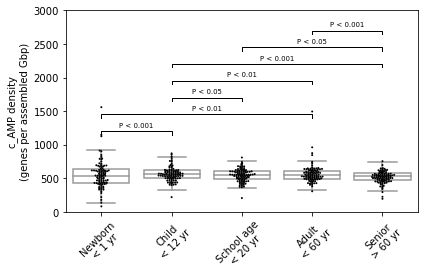

In [13]:
# analysis by age
sns.boxplot(data=it,
            y='density',
            x='group',
            showfliers=False,
            order=['newborn',
                  'child',
                  'teenager',
                  'adult',
                  'senior'],
            color='white')

innersample = pd.DataFrame()
for x in set(it['group'].dropna()):
    ix = it[it['group'] == x].sample(100)
    innersample = pd.concat([innersample,
                            ix])
    
sns.swarmplot(data=innersample,
              y='density',
              x='group',
              s=2, 
              order=['newborn',
                  'child',
                  'teenager',
                  'adult',
                  'senior'],
              color='black')

plt.xlabel('')
plt.ylabel('c_AMP density\n(genes per assembled Gbp)')

plt.xticks([0, 1, 2, 3, 4],
           ['Newborn\n< 1 yr',
            'Child\n< 12 yr',
            'School age\n< 20 yr',
            'Adult\n< 60 yr',
            'Senior\n> 60 yr'],
          rotation=45)

# statistical annotation
mann = []
with open('age_factor_comparison_density.tsv',
          'wt') as ofile:
    ofile.write(f'group_1\tgroup_2\tU_statistic\tP_value\n')
    combs = combinations(set(it['group'].dropna()), 2)
    for i, j in combs:
        u, p = mannwhitneyu(it.loc[(it['group'] == i), 'density'],
                            it.loc[(it['group'] == j), 'density'])
        ofile.write(f'{i}\t{j}\t{u}\t{p}\n')
        mann.append((i, j, p))

xdict = {'newborn': 0,
         'child': 1,
         'teenager': 2,
         'adult': 3,
         'senior': 4}

newmann = []
for i, j, p in mann:
    x1, x2 = xdict[i], xdict[j]
    if x1 < x2: newmann.append((x1, x2, p))
    else: newmann.append((x2, x1, p))

newmann = pd.DataFrame(newmann,
                       columns=['a', 'b', 'p'])

newmann = newmann.sort_values(by=['a', 'b'])
newmann = newmann[newmann.p < 0.05]
newmann = newmann.reset_index(drop=True)

def classp(x):
    if x < 0.001: return 'P < 0.001'
    if x < 0.01: return 'P < 0.01'
    if x < 0.05: return 'P < 0.05'

for idx, x1, x2, p in newmann.itertuples():
    y, h, col = 1200, idx*250, 'k'
    plt.plot([x1, x1, x2, x2],
             [y+(h-50), y+h, y+h, y+(h-50)],
             lw=1.0,
             c=col)
    plt.text((x1+x2)*.5,
              y+(h+50),
              classp(p),
              ha='center',
              va='bottom',
              fontsize='x-small',
              color=col)

    plt.ylim(0,3000)
plt.tight_layout()
plt.savefig('age_factor.svg')


Mann-Whitney U test between Westernized and Non-westernized communities:
Statistic: 1054699.0
P-value: 0.014263114417438999


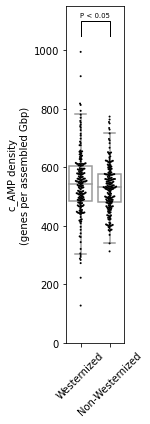

In [14]:
# analysis by western
u, p = mannwhitneyu(it.loc[(it['western'] == 'True'), 'density'],
                    it.loc[(it['western'] == 'False'), 'density'])
print(f'''
Mann-Whitney U test between Westernized and Non-westernized communities:
Statistic: {u}
P-value: {p}''')

fig = plt.gcf()
fig.set_size_inches(2, 6)

sns.boxplot(data=it,
            y='density',
            x='western',
            showfliers=False,
            order=['True', 'False'],
            color='white')

innersample = pd.DataFrame()
for x in ['True', 'False']:
    ix = it[it['western'] == x].sample(200)
    innersample = pd.concat([innersample,
                            ix])
    
sns.swarmplot(data=innersample,
              y='density',
              x='western',
              s=2, 
              order=['True', 'False'],
              color='black')

plt.xlabel('')
plt.ylabel('c_AMP density\n(genes per assembled Gbp)')

plt.xticks([0,1],
           ['Westernized', 'Non-Westernized'],
          rotation=45)

#statistics annotation
x1, x2 = (0, 1)
y, h, col = 1100, 0, 'k'
plt.plot([x1, x1, x2, x2],
         [y+(h-50), y+h, y+h, y+(h-50)],
         lw=1.0,
         c=col)

plt.text((x1+x2)*.5,
          y+(h+10),
          classp(p),
          ha='center',
          va='bottom',
          fontsize='x-small',
          color=col)

plt.ylim(0,1150)
plt.tight_layout()
plt.savefig('western_factor.svg')